In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [3]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) 
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

        
def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0  
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    #ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This cell reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_myocardium/case272.tif [one image]
2. images_blood_cells/000016.png [several images available]


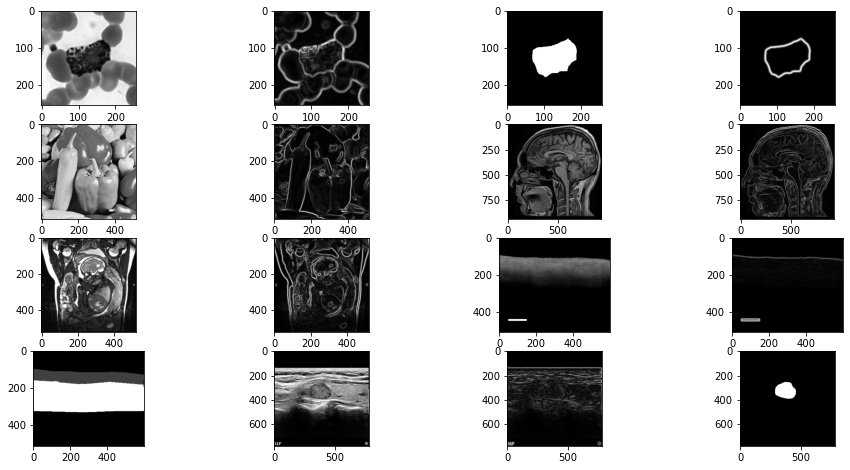

In [4]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

img_star          = skimage.io.imread('./images_misc/smooth_star.png', as_gray = True)
img_star_noisy    = skimage.io.imread('./images_misc/smooth_star_noisy.png', as_gray = True)

img_hela    = skimage.io.imread('./images_misc/hela_big_gt.png', as_gray = True)
edge_hela   = edge_map(img_hela, sigma=2)

img_pepper  = skimage.io.imread('./images_misc/peppers_gt.png', as_gray = True)
edge_pepper = edge_map(img_pepper, sigma=2)
img_pepper  = img_pepper.astype('float64')

img_MRIb  = skimage.io.imread('./images_misc/MRI_brain_sag.png', as_gray = True)
edge_MRIb = edge_map(img_MRIb, sigma=2)
img_MRIf  = skimage.io.imread('./images_misc/MRI_fetus.png', as_gray = True)
edge_MRIf = edge_map(img_MRIf, sigma=2)


img_cell  = skimage.io.imread('./images_blood_cells/000016.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)

img_mask = skimage.io.imread('./masks_blood_cells/000016.png', as_gray = True)
edge_mask = edge_map(img_mask, sigma=2)
# skimage.io.imshow(img_mask)

img_OCT  = skimage.io.imread('./OCT_myocardium/case272.tif', as_gray = True)
edge_OCT = edge_map(img_OCT, sigma=2)
labels_OCT = skimage.io.imread('./OCT_myocardium/case272_label.tiff', as_gray = True)


img_nodule = skimage.io.imread('./thyroid_nodule/1074.png', as_gray = True)
edge_nodule = edge_map(img_nodule, sigma=2)
labels_nodule = skimage.io.imread('./thyroid_nodule/1074_mask.png', as_gray = True)


fig, axes = plt.subplots(4,4, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(img_mask, cmap=plt.cm.gray);
ax[3].imshow(edge_mask, cmap=plt.cm.gray);
ax[4].imshow(img_pepper, cmap=plt.cm.gray);
ax[5].imshow(edge_pepper, cmap=plt.cm.gray);
ax[6].imshow(img_MRIb, cmap=plt.cm.gray);
ax[7].imshow(edge_MRIb, cmap=plt.cm.gray);
ax[8].imshow(img_MRIf, cmap=plt.cm.gray);
ax[9].imshow(edge_MRIf, cmap=plt.cm.gray);
ax[10].imshow(img_OCT, cmap=plt.cm.gray);
ax[11].imshow(edge_OCT, cmap=plt.cm.gray);
ax[12].imshow(labels_OCT, cmap=plt.cm.gray);
ax[13].imshow(img_nodule, cmap=plt.cm.gray);
ax[14].imshow(edge_nodule, cmap=plt.cm.gray);
ax[15].imshow(labels_nodule, cmap=plt.cm.gray);

# Image properties: 
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


float64
0.04579333333333333
255.0


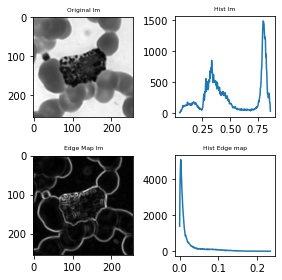

In [5]:

img_test  = img_cell
Sigma_val = 1
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print(img_test.dtype)
print(np.min(img_test))
print(np.max(img_pepper))


## Show Hist
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map. 

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use. 
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero. 

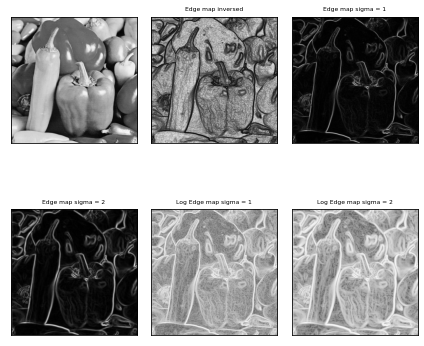

In [6]:

img_to_test = img_pepper

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test1_l       = np.log2(edge_test1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2(edge_test2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(img_to_test, alpha=1.0, sigma=1.0) 


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[1].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[1].set_title("Edge map inversed", fontsize=6);
ax[2].imshow(edge_test1, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 1", fontsize=6);
ax[3].imshow(edge_test2, cmap=plt.cm.gray);
ax[3].set_title("Edge map sigma = 2", fontsize=6);
ax[4].imshow(edge_test1_l, cmap=plt.cm.gray);
ax[4].set_title("Log Edge map sigma = 1", fontsize=6);
ax[5].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[5].set_title("Log Edge map sigma = 2", fontsize=6);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

# Test some image manipulations

Let you test some image transformations based on morphological operators and histogram manipulation. 
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

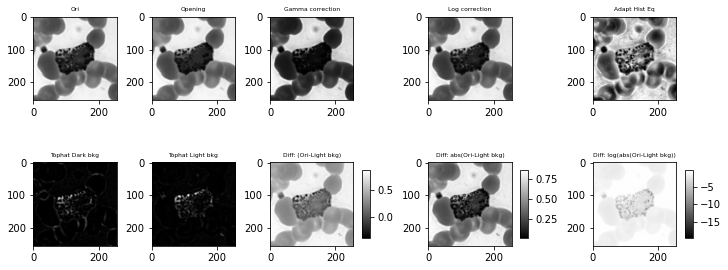

In [7]:
img_ori_to_test = img_cell
img_to_test     = img_ori_to_test

PRE_ENHANCE     = 1
OPTION_ENHANCE  = 0 # can be 0 (nothing) to 4

# Run all  OPTION_ENHANCE for display here       
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 2)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 5
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=6);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=6);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=6);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=6);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=6);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=6);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=6);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1: 
### Snake on a binary shape

Based on the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br> 
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark 
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges

 
## TODO:
1. Run the cell for **img_to_seg=img_mask** with the sets of parameter values provided. 1st set uses values by default, 2nd-3rd sets use custom values to help improve the smoothness of the final contour. <br>

    Q - Comment on defaults seen on the obtained initial segmentations. <br>
    A - La première segmantation n'est pas très lisse <br>
      
    Q - Explain why you think increasing the gamma_val has better helped smooth the final contour.  
    A - En augmentant la valeur de gamma, le contour sera plus lisse, car la fonction d'énergie sera plus fortement influencée par la viscosité. pour Béta, c'est l'énergie interne qui sera directement influencée. Ainsi, même si Béta permet de lisser, il est dépendant du contour, donc sur des variations fortes du contour (angle), gamma permet d'éviter les abérations duent aux lissages  <br>  <br>

2. Test now by using a small initial circle inside the white shape. <br>
    Q - What is happening and what additional force seen in the class could help fixing this issue? <br>
    A - Avec un cercle plus petit, l'ensemble du contour n'est pas atteint par la segmentation. Avec une $F_{externale}=Baloon$ vu en cours, on peut espérer palier à ce problème en étendant la forme.<br>  <br>

3. Now run the segmentation on the **img_to_seg=img_star** or **img_to_seg=img_star_noisy**. Try the same parameter values adjustments as before to get a smoother final contour. 

    Q - Comment on the issues observed with the two options.
    A - Pour l'image img_star et img_star_noisy, les paramètres d'ajustements donnent des résultats qui ne sont pas satisfaisants. La précision n'est pas du tout bonne. On en déduit que les paramètres sont des hyperparamètres dont les valeurs "optimales" dépendent de la forme pour laquelle on souhaite trouver le contour.


4. BONUS: there is a way to obtain a "perfect" segmentation for the star shape. 

    Q - Propose one solution which might involve many more iterations, once you have checked with few iterations that behavior is stable. <br>
    A - En augmentant le paramètre max_iterations de active_contours de skimage, on obtient un résultat satisfaisant. Ainsi, avec la valeur par défaut de skimage, le résultat est très bon.


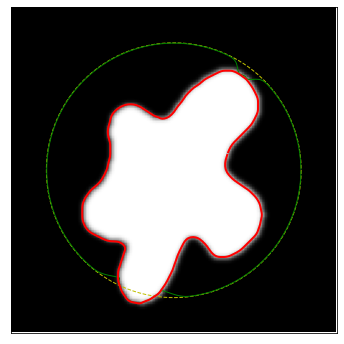

In [8]:
# 1ST image
#img_to_seg=img_mask; r0 = 130; c0=125; R0 = 60
#alpha_val  = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4;Niter_snake = 800; 
#alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.1; convergence_val = 1e-4; Niter_snake = 800; 
#alpha_val  = 0.01 ; beta_val = 1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800; 

# 2ND image
img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
#img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50
alpha_val  = 0.1 ; beta_val = 0.1; gamma_val = 0.1; convergence_val = 1e-4; Niter_snake = 800; 


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image 
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour 
snake10 = active_contour(img_to_seg,
                       init, convergence=convergence_val, max_iterations = 10,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, convergence=convergence_val, max_iterations = Niter_snake,
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6));
ax.imshow(img_to_seg, cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=1);
ax.plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax.plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax.set_xticks([]), ax.set_yticks([]);
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);

plt.show();

# Seg #2: 
### Snake on a real image 

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask of the target segmentation for the dark cell.  

## TODO
1. **Segment left cell**: 
    Run with the proposed initialisation and see that the active contour can be initialised inside the object. 
    
    Q - Give some intuition on why. <br>
    A - L'image n'est plus binaire, ainsi on a un dégradé qui permet d'avoir des variations de gradient constante de l'intérieur vers l'extérieur de la cellule. Comme la fonction active_contours maximise le gradient, elle entraine le contour vers l'extérieur de la cellule. <br> <br>
    
2. **Segment right cell**:

    Q -  Run with the proposed initialisation and see that the active contour cannot be initialised inside the object now. Give some intuition on why. <br>
    A - Ici, on a des variations de gradient à l'intérieur de la cellule. La gradient n'est donc pas guidé vers l'extérieur de la cellule, car il reste sur un minimum local. <br> <br>
    
    Q - Change the parameter **Niter_smooth** while keeping snake parameters constant and give an intuition on why the final contour evolves as seen. 
    A - En fixant Niter_smooth = 5, on obtient un resultat un peu plus satisfaisant. En lisant l'image, les variations locales du gradient diminuent, ainsi les variations globales gagnent en importance et le programme est un peu plus efficace. Cela reste insuffisant pour pouvoir pleinement segmenter la cellule. Avec des valeurs encore plus élevé, l'image est trop flou pour être correctement segmentée.
    
    Q - Change the initial contour parameters to obtain a perfect segmentation.
    A - r0 = 130; c0=120; R0 = 55; alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800; <br> <br>
    
3. BONUS: If you know that you are aiming for the darkest cell in the image, propose an automated initialisation of the initial active contour parameters [r0 ; c0; R0 ] that works on this image.



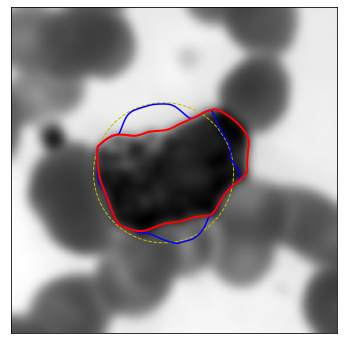

In [9]:

# Input image and parameter values
img_to_seg   =  img_cell; 

# 1st SEG: To segment left cell
#r0 = 150; c0=50; R0 = 30
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 55 
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 800;



# Pre smooth the image
Niter_smooth = 4
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Run active contour 
snake30 = active_contour(img_to_seg,
                       init, convergence=convergence_val, max_iterations = 30,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, convergence=convergence_val, max_iterations = Niter_snake,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

# Seg # 3

### A tool to visualise the deformations of the snake


## TO DO:
1. **Segment left cell**:

    Q - Provide your comments on the deformation pattern of the snake. <br>
    A - La vidéo permet de comprendre comment la descente de gradient permet au snake en partant du centre de rejoindre les contours de la cellule, en suivant l'intensité de l'image.
    
    Q - Why iteration time steps get slower over iterations when initialising from the inside? <br>
    A - Le nombre de points est plus important, ce qui augmente le temps de calcul <br> <br>
    
1. **Segment right cell**: 

    Q - Use your optimal parameters from previous cell and comment on the deformation patterns. <br>
    A - On voit les étapes se réaliser, et le résultat est satisfaisant.

start
1  51  101  151  201  251  301  351  401  451  501  551  601  651  701  751  801  851  901  951  stop


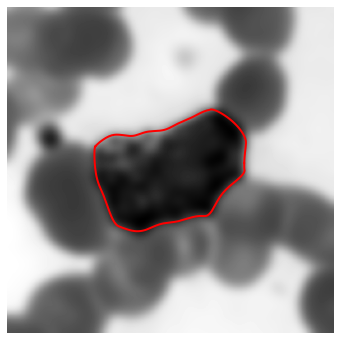

In [17]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
#r0 = 150; c0=50; R0 = 30
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 50 # initialise inside
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 1000;

# Pre smooth the image
Niter_smooth = 4
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,50):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_iterations=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO: 

1.    Q - Compare results when segmenting the Edge_map or GVF_map as input to the active_contour routine on 3 images: img_star, img_star_noisy and an image of your choice. Comment on robustness and speed differences. 
    A -  Il est nécessaire d'avoir Niter_snake = 1000 pour avoir assez d'itérations. La convergence est plus rapide sans bruit. La segmentation avec GVF_map est meilleure pour l'image sans bruit. Pour im_star_noisy, le resultat donné par im_star_noisy est satisfaisant mais n'est pas smooth. GVF_map poermet d'avoir un resultat smooth, mais la segmentation est mauvaise. 
    Edge_map réussi bien plus robuste au bruit, mais propose un resultat moins smooth. GVF_map a une vitesse d'execution plus rapide.

2.  Q - When using GVF_map, test the effect of decreasing by a factor of 10 alpha,beta or gamma and interpret the effect.
A - Pour alpha, une diminution entraîne une augmentation légère de la vitesse de contraction du contours.
Pour beta, une diminution entraîne davantage d'irrégularités sur le contour, ce qui est normal puisqu'il caractérise la rigidité du contour.
Pour gamma, une diminution entraîne aussi un contours plus irrégulié, gamma caractérise la viscosité du milieu.


................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891  901  911  921  931  941  951  961  971  981  991  stop


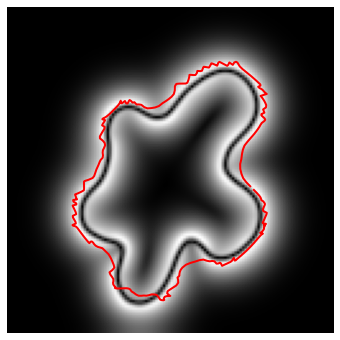

In [20]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

# Example of another image to test. 
# NB: play with regularisation  parameter mu for gradient_vector_flow on real images
# img_to_seg        = img_cell
# r0 = 130; c0=120; R0 = 50 # initialise inside

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.001; 
convergence_val = 1e-4; Niter_snake = 1000; 


# Initialise contour 
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(Edge_map)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_iterations=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working now with the img_nodule which is an ultrasound showing different layers of tissue under the skin surface.

## TO DO:
* Write a loop to vary the initial line vertical position by few pixels and propose a method to aggregate final contours, like for example a probability edge map. 
* BONUS: Propose and implement a metric to measure the "quality" of the segmented contour, as being representative of the "interface" between two tissues. 


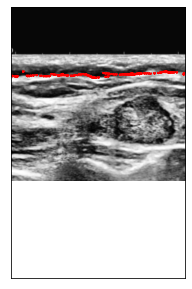

In [24]:
img_to_seg = img_nodule
r_left = 170; r_right=170; c_left=0; c_right = 780
#r_left = 200; r_right=190; c_left=0; c_right = 780
#r_left = 230; r_right=210; c_left=0; c_right = 780

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=0; w_edge_val=1

# Pre smooth the image
img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
Nber_pts_contour = 300
(n,m) = img_to_seg.shape
prob_map = np.zeros((n+1,m+1))
for k in range (5):
  r_left = 190 + 2*k
  r_right = 190 + 2*k
  r          = np.linspace(r_left, r_right, Nber_pts_contour)
  c          = np.linspace(c_left, c_right, Nber_pts_contour)
  init       = np.array([r, c]).T
  snake = active_contour(img_to_seg,
                       init, boundary_condition='fixed-fixed',max_iterations=Niter_snake,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                       w_line=w_line_val, w_edge=w_edge_val)
  for i, j in snake :
    prob_map[int(i),int(j)] += 1

final_snake = prob_map > 1

fig, ax = plt.subplots(figsize=(9, 5));
ax.imshow(img_to_seg[0:500,:], cmap=plt.cm.gray);
plt.contour(final_snake,colors='r',linewidths=2)
ax.set_xticks([]), ax.set_yticks([]);
ax.set(xlim=(0, 500));
plt.show();

BONUS

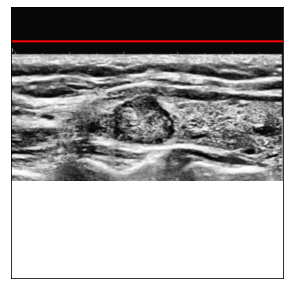

1.0


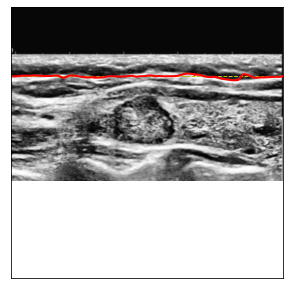

1.35


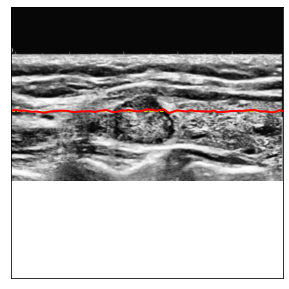

1.3


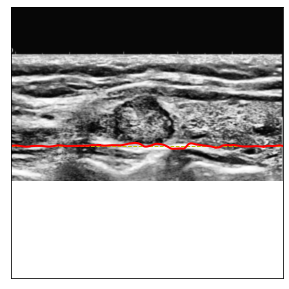

2.1933333333333334


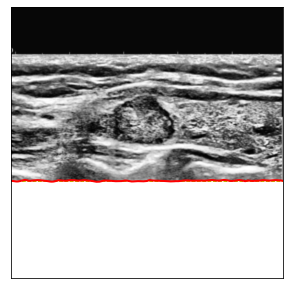

1.0


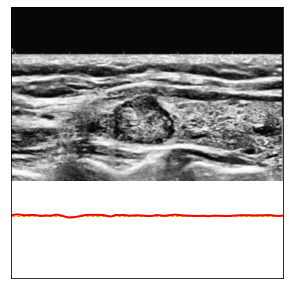

0.0


In [40]:
def mesure_qualite(row):
  c_left=0; c_right = 780
  r          = np.linspace(row, row, Nber_pts_contour)
  c          = np.linspace(c_left, c_right, Nber_pts_contour)
  init       = np.array([r, c]).T
  snake = active_contour(img_to_seg,
                       init, boundary_condition='fixed-fixed',max_iterations=Niter_snake,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                       w_line=w_line_val, w_edge=w_edge_val)
  fig, ax = plt.subplots(figsize=(9, 5));
  ax.imshow(img_to_seg[0:500,:], cmap=plt.cm.gray);
  ax.set_xticks([]), ax.set_yticks([]);
  ax.set(xlim=(0, 500));
  ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
  ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
  ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])
  plt.show();
  S = np.array([prob_map[int(i), int(j)] for i, j in snake]).sum()
  return S/snake.shape[0]

for i in range (6):
  print(mesure_qualite(100 + i*100))

# Seg # 6

### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO: 
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria. 

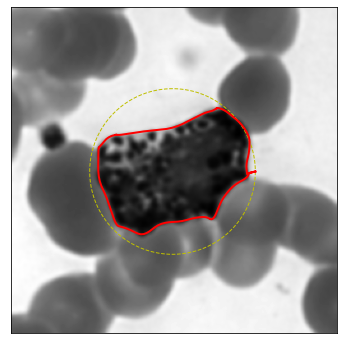

In [43]:
img_to_seg = img_cell
Niter_smooth = 1

# Pre filter the image
img_to_seg = gaussian(img_to_seg, 1, preserve_range=True)

# Manually position the initial contour
r0, c0, R0 = 129,127,65
init = define_initial_circle(R0,r0,c0)

# Run active contour model
alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 500; w_line_val=0; w_edge_val=1
snake = active_contour(img_to_seg,
                  init, boundary_condition='fixed-fixed',max_iterations=Niter_snake,
                  alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                  w_line=w_line_val, w_edge=w_edge_val)
  

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show(); 

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model. 
Skimage provides two implementations of the Chan-Vese approach: **morphological_chan_vese** and **chan_vese**. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms. 
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on img_hela. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration. 





1. Phi est une image aléatoire, et au fur et à mesure des itérations, Phi se contraste pour correspondre à l'image, jusqu'à arriver au maximum d'itérations, ici 46

In [70]:

img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    cv0 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=0, init_level_set=Init_method,
                   extended_output=True)
    cv10 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=10, init_level_set=Init_method,
                   extended_output=True)
    cv20 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=20, init_level_set=Init_method,
                   extended_output=True)
    cv30 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=30, init_level_set=Init_method,
                   extended_output=True)
    cv40 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=40, init_level_set=Init_method,
                   extended_output=True)
    cv50 = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=50, init_level_set=Init_method,
                   extended_output=True)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, iterations=Num_iter_cv_fast, 
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

Text(0.5, 1.0, 'Phi with - 0 iterations')

Text(0.5, 1.0, 'Phi with - 10 iterations')

Text(0.5, 1.0, 'Phi with - 20 iterations')

Text(0.5, 1.0, 'Phi with - 30 iterations')

Text(0.5, 1.0, 'Phi with - 40 iterations')

Text(0.5, 1.0, 'Phi with - 46 iterations')

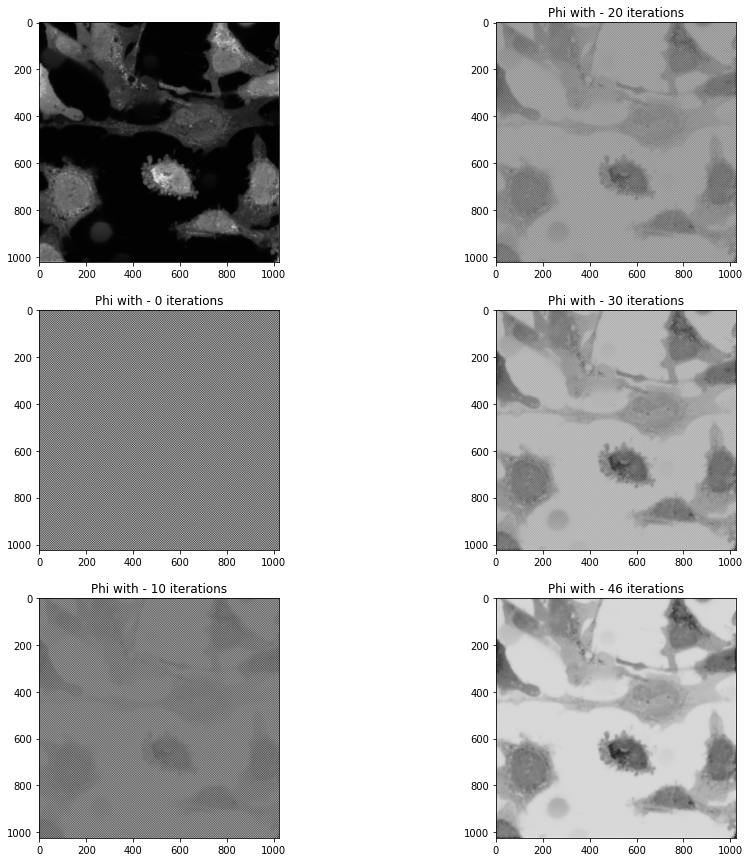

In [67]:
fig, ax = plt.subplots(3,2,figsize=(15, 15))
ax[(0,0)].imshow(img_to_seg, cmap=plt.cm.gray)
ax[(1,0)].imshow(cv0[1], cmap=plt.cm.gray)
title = f'Phi with - {len(cv0[2])} iterations'
ax[(1,0)].set_title(title, fontsize=12)
ax[(2,0)].imshow(cv10[1], cmap=plt.cm.gray)
title = f'Phi with - {len(cv10[2])} iterations'
ax[(2,0)].set_title(title, fontsize=12)
ax[(0,1)].imshow(cv20[1], cmap=plt.cm.gray)
title = f'Phi with - {len(cv20[2])} iterations'
ax[(0,1)].set_title(title, fontsize=12)
ax[(1,1)].imshow(cv30[1], cmap=plt.cm.gray) 
title = f'Phi with - {len(cv30[2])} iterations'
ax[(1,1)].set_title(title, fontsize=12)
ax[(2,1)].imshow(cv40[1], cmap=plt.cm.gray) 
title = f'Phi with - {len(cv40[2])} iterations'
ax[(2,1)].set_title(title, fontsize=12)
ax[(2,1)].imshow(cv50[1], cmap=plt.cm.gray) 
title = f'Phi with - {len(cv50[2])} iterations'
ax[(2,1)].set_title(title, fontsize=12)

2. Run now on img_cell without and with pre-processing with histogram equalisation and explain difference in results.

L'égalisation d'histogramme limite les différences entre les deux régions. Ainsi, la détection est moins bonne, notamment l'influance de la lumière et des ombres sur la détection est plus forte, il y a alors plus de confusions.

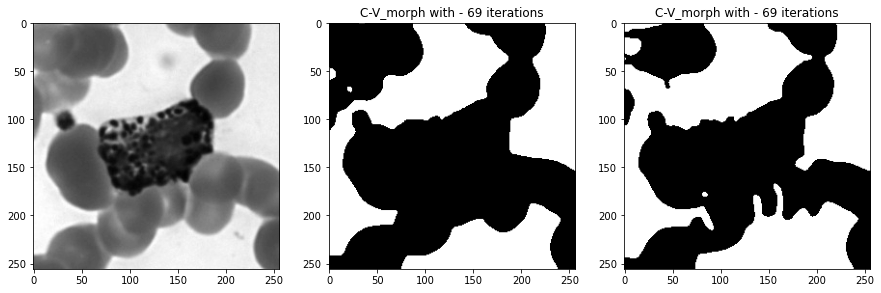

In [63]:
from skimage import exposure

img_to_seg = img_cell
img_to_seg_withpp = exposure.equalize_hist(img_cell)

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    cvpp = chan_vese(img_to_seg_withpp, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,3,figsize=(15, 15))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V_morph with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)
    ax[2].imshow(1-cvpp[0], cmap=plt.cm.gray)
    title = f'C-V_morph with - {len(cvpp[2])} iterations'
    ax[2].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, iterations=Num_iter_cv_fast, 
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();


3. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here. 


On peut utiliser dice qui est un moyen de mesurer les faux positifs et les faux négatifs. On remarque que la méthode plus rapide est nettement moins précise (0.8 pour la lente contre 0.6 sans pre-processing et 0.67 avec pour la rapide).

In [65]:
def dice(inputs,target):
  num = target.shape[0]   #nombre de lignes
  inputs = inputs.reshape(num, -1)  #On forme des vecteurs colonnes (pour la multiplication terme à terme suivante)
  target = target.reshape(num, -1)
  smooth = 1.0
  intersection = (inputs * target)
  dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
  dice = dice.sum() / num
  return dice

print("Dice score without pre-processing is {}".format(dice(cv[0],img_mask)))
print("Dice score with pre-processing is {}".format(dice(cvpp[0],img_mask)))

Dice score without pre-processing is 0.7964000329212644
Dice score with pre-processing is 0.7932293835931463


In [71]:
print("Dice score fast method without pre-processing is {}".format(dice(cv[0],img_mask)))
print("Dice score fast method with pre-processing is {}".format(dice(cvpp[0],img_mask)))

Dice score fast method without pre-processing is 0.6074827592942036
Dice score fast method with pre-processing is 0.6699762629491012


4. Make the level set work when initialising with "disk" on img_MRIf

On a un résultat peu satisfaisant et le résultat s'arrête à la première itération

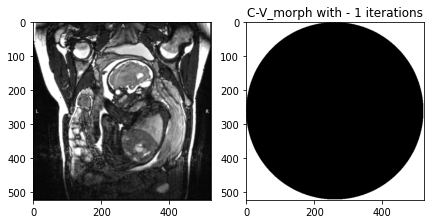

In [74]:

img_to_seg= img_MRIf

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "disk" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)    
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, iterations=Num_iter_cv_fast, 
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* Thresh_cont_val  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)
* Balloon_weight   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflat
* Smooth_cont_iter = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
* Segment the img_cell with the provided configuration in line 1 to inflate the initial contour. What is the issue?



Le problème est dû a un minimum local. L'algorithme décrète donc qu'un morceau de la cellule est une autre cellule, il manque donc un morceau (en haut à gauche). Par contre, l'algorithme propose une segmentation plutôt précise.

0.7377611236173724


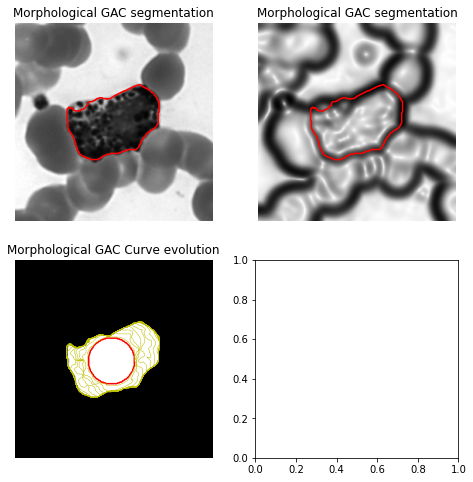

In [75]:


img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ; 
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();


* Now Segment the img_cell with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations. 

Le problème est qu'il ne dégonfle pas (baloon_weight > 0). Il faut qu'il dégonfle ici, on prend donc baloon_weight = -1.

0.7377611236173724


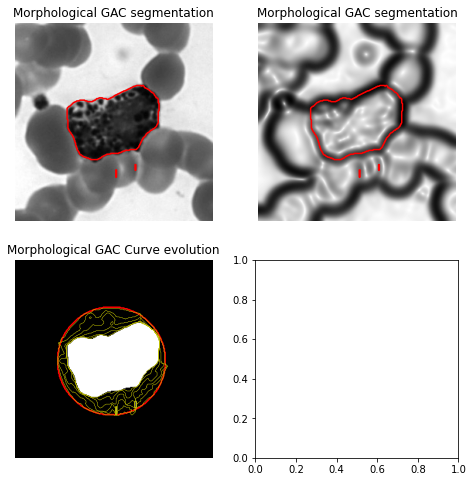

In [79]:


#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = -1 ; Smooth_cont_iter = 1 ; 
Niter_snake      = 30

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();

* Segment the img_MRIb image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularisation over 300 iterations. 

Avec une smoothness regularisation de 1, le resultat correspond à la segmentation de la zone large correspondante. Avec une smoothness regularisation plus grande, le resultat est plus restreint est toute la zone n'est pas couverte.

0.785146875520775


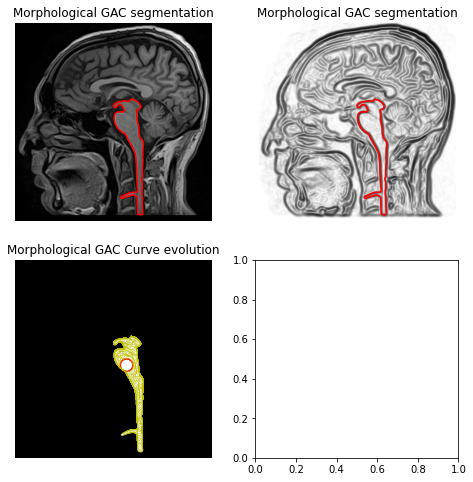

In [80]:


#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ; 
Niter_snake      = 300

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();

* Now propose and run a setup to attempt to segment the gray matter contours in img_MRIb or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours. 

Avec les paramètres r0 = 270 ; c0 = 670 ; R0 = 130 ; Niter_snake = 470 on obtient un résultat satisfaisant. La partie du cerveau contenant le liquide céphalo-rachidien est tout de même pris dans la segmentation.

0.785146875520775


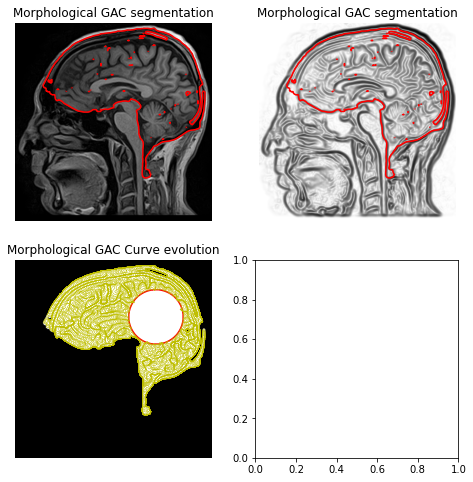

In [51]:


#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
img_to_seg = img_MRIb ; r0 = 270 ; c0 = 670 ; R0 = 130  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force 

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ; 
Niter_snake      = 470

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto" 
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour 
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');
    
plt.show();